<a href="https://colab.research.google.com/github/Jwilson1172/DS-Unit-1-Sprint-2-Statistics/blob/master/module2/LS_DS_122_Sampling_Confidence_Intervals_and_Hypothesis_Testing_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment - Build a confidence interval
 
A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [0]:
# coping and pasting to get the df's set up
import numpy as np
import pandas as pd
from scipy import stats

# column headers
names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

# init the datra frame from csv
df=pd.read_csv('/content/house-votes-84.data',names=names)
# make sure that the changes persisted
df=df.replace({'n':0,'y':1,'?':np.NaN})

# split into two diffrent dataframes
rep=df[df['party']=='republican']
dem=df[df['party']=='democrat']


## Confidence Intervals




###1. Generate and numerically represent a confidence interval:

In [0]:
# define a function that finds the CI's of a sample with a 95% confindence level
def CI(data, confidence=0.95):

  # find the mean of the data
  mean = np.mean(data)
  # find the size of the sample
  n = len(data)
  # calculate standard error
  stderr = stats.sem(data,nan_policy='omit')
  # Look up the t-statistic that contains 95% of possible sample means
  # within its bounds
  t = stats.t.ppf((1 + confidence) / 2.0, n - 1)
  # calculate the margin of error
  margin_of_error = t * stderr
  # return the CI bounds and the mean as a tuple
  return mean - margin_of_error, mean, mean + margin_of_error


In [0]:
# make a funtion to re sample my data so that (hopefully) is is not biased
# down party lines

def re_sample(df):
  s1=df.sample(frac=0.5,random_state=200)
  s2=df.drop(s1.index)
  return s1, s2

dem,rep=re_sample(df)

In [0]:


print("BILL: BUDGET\n")

ci_l,m,ci_h = CI(df['budget'])
pop_stats=[ci_l,m,ci_h]
print("\npopulation:(KNOWN STATS)")
print(f"\tConfidence_low={ci_l},\n\tMean:{m},\n\tConfidence_high{ci_h}\n")
ci_l,m,ci_h = CI(dem['budget'])
dem_stats=[ci_l,m,ci_h]
print("\nsample 1")
print(f"\tConfidence_low={ci_l},\n\tMean:{m},\n\tConfidence_high{ci_h}\n")
ci_l,m,ci_h = CI(rep['budget'])
print("\nsample 2")
print(f"\tConfidence_low={ci_l},\n\tMean:{m},\n\tConfidence_high{ci_h}\n")



BILL: BUDGET


population:(KNOWN STATS)
	Confidence_low=0.5498185901307273,
	Mean:0.5966981132075472,
	Confidence_high0.643577636284367


sample 1
	Confidence_low=0.5666420536296656,
	Mean:0.6320754716981132,
	Confidence_high0.6975088897665608


sample 2
	Confidence_low=0.4939880380797327,
	Mean:0.5613207547169812,
	Confidence_high0.6286534713542297



###2. Graphically (with a plot) represent the confidence interval

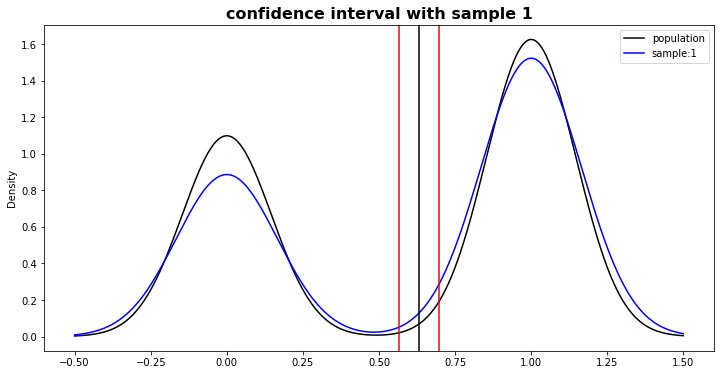

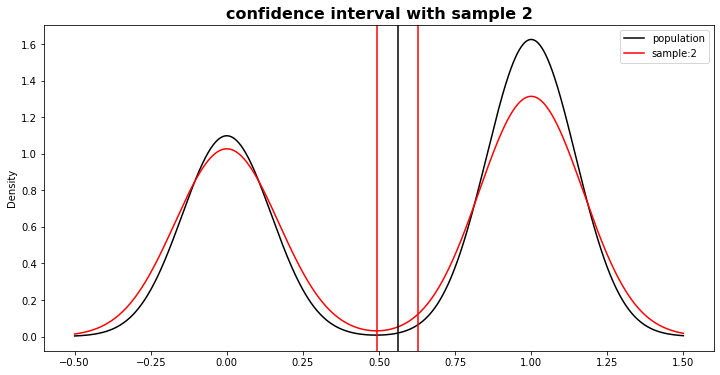

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[12,6]

######################################################################
##              first sample                                        ##
######################################################################
#population CI's
df['budget'].plot(kind='kde',color='k')

# find the CI's for the first sample
dem['budget'].plot(kind='kde',color='blue')
plt.axvline(x=dem_stats[0], color='red')
plt.axvline(x=dem_stats[1], color='black')
plt.axvline(x=dem_stats[2], color='red');

plt.title("confidence interval with sample 1",fontsize=16,fontweight='bold')
plt.legend(['population','sample:1'])
plt.show()

######################################################################
##              second sample                                       ##
######################################################################

#population CI's
df['budget'].plot(kind='kde',color='k')

# find the CI's for the second sample
rep['budget'].plot(kind='kde',color='red')
plt.axvline(x=ci_l, color='red')
plt.axvline(x=m, color='black')
plt.axvline(x=ci_h, color='red');

plt.title("confidence interval with sample 2",fontsize=16,fontweight='bold')
plt.legend(['population','sample:2'])
plt.show()

###3. Interpret

based on a Confidence Interval of 95% we can exspect the mean value of the population that will suport the 'budget' bill to be between 49% to 62%

#Chi squared test's

In [0]:
# setting up things
import zipfile
# path to my data set .csv
path_local='/content/bank-additional/bank-additional-full.csv'

# use the zipfile module to extract zip
def fetch_unzip():

  # download my .zip with curl because its soo much easier
  # note because im pulling a zip i use the --raw so that i dont impose an encoding
  # encoding to the zip file, i want to get it as it is from the source
  !curl --raw 'https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip' >'/content/bank_additional.zip'
  zip_ref=zipfile.ZipFile('/content/bank_additional.zip')
  zip_ref.extractall('/content/')
  # make sure i close my zip file
  zip_ref.close()
  return

# call my zip fetching function and print a few lines from the .csv
fetch_unzip()
df=pd.read_csv(path_local,sep=r';')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  434k  100  434k    0     0   652k      0 --:--:-- --:--:-- --:--:--  653k


In [0]:
# get a list of catigorical dtypes
df.select_dtypes(include=['object'])
cross=pd.crosstab(df['job'],df['education'],margins=True,margins_name='Total')
cross.shape

(13, 9)

In [0]:
# git the bound of the sum columns in the cross tab
row_sums = cross.iloc[0:14, 2].values
col_sums = cross.iloc[2, 0:10].values

# print the row and column sum values
print(f"row_sums:{row_sums}")
print(f"column_sums:{col_sums}")
# get our final total
total_total = cross.iloc[-1,-1]
expected = []
# interate through each row
for i in range(len(row_sums)):
  expected_row = []
  # interate through each column and find the exspeced value
  for column in col_sums:
    expected_val = column*row_sums[i]/total_total
    expected_row.append(expected_val)
  expected.append(expected_row)
# convert the list to a np array
expected = np.array(expected)
# print out the variables
print(f"Expected values shape:{expected.shape}")  
print(f"expected values:\n{pd.DataFrame(expected,columns=cross.columns)}")

row_sums:[ 499 3623  210   94  166  145  220  388   99  384  186   31 6045]
column_sums:[ 137   71  210  234    2  135  610   57 1456]
Expected values shape:(13, 9)
expected values:
education   basic.4y   basic.6y  ...   unknown       Total
0           1.659780   0.860178  ...  0.690565   17.639701
1          12.050864   6.245338  ...  5.013863  128.073419
2           0.698504   0.361999  ...  0.290619    7.423521
3           0.312664   0.162037  ...  0.130086    3.322910
4           0.552151   0.286151  ...  0.229727    5.868117
5           0.482301   0.249951  ...  0.200665    5.125765
6           0.731767   0.379237  ...  0.304458    7.777022
7           1.290570   0.668836  ...  0.536953   13.715840
8           0.329295   0.170657  ...  0.137006    3.499660
9           1.277265   0.661940  ...  0.531417   13.574439
10          0.618675   0.320627  ...  0.257405    6.575119
11          0.103113   0.053438  ...  0.042901    1.095853
12         20.106949  10.420389  ...  8.365665  213

In [0]:
# get the crosstab without margins
observed=cross.values

# calucate the chi square
chi_squared = ((observed - expected)**2/(expected)).sum() 
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 60188848.25529992


In [0]:
# one liner
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 37338.1351562161
P-value: 0.0
Degrees of Freedom: 96
Expected: 
 [[1.05667359e+03 5.79955909e+02 1.52959576e+03 2.40762674e+03
  4.55462756e+00 1.32666179e+03 3.07892823e+03 4.38003350e+02
  1.04220000e+04]
 [9.38251530e+02 5.14959891e+02 1.35817301e+03 2.13780252e+03
  4.04418763e+00 1.17798199e+03 2.73387084e+03 3.88916044e+02
  9.25400000e+03]
 [1.47622026e+02 8.10224337e+01 2.13691366e+02 3.36356220e+02
  6.36301835e-01 1.85340585e+02 4.30140041e+02 6.11910265e+01
  1.45600000e+03]
 [1.07472079e+02 5.89861125e+01 1.55572011e+02 2.44874721e+02
  4.63241721e-01 1.34932019e+02 3.13151403e+02 4.45484122e+01
  1.06000000e+03]
 [2.96460717e+02 1.62712635e+02 4.29143925e+02 6.75484607e+02
  1.27784792e+00 3.72208702e+02 8.63825192e+02 1.22886375e+02
  2.92400000e+03]
 [1.74388657e+02 9.57133146e+01 2.52437603e+02 3.97343887e+02
  7.51675245e-01 2.18946295e+02 5.08132466e+02 7.22861027e+01
  1.72000000e+03]
 [1.44073419e+02 7.90747791e+01 2.08554555e+02 3.28270734e+02
  6.2100

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)